# Analyzing Distributed Data with Spark

## Initialisierung der Spark Application

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions
from pyspark.sql.functions import to_timestamp, to_date, year
from scipy import stats

In [2]:
# Spark session & context
spark = SparkSession \
    .builder \
    .master('spark://spark-master:7077') \
    .appName("uebung_26") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
sc = spark.sparkContext

In [3]:
# Load a text file and inspect it
def read_and_format_csv(path, sep=',', header=True, date_col=None):
    # Read in the dataframe
    df = spark.read.csv(
        path=path, 
        sep=sep,
        header=header,
        inferSchema=True
    )
    
    # Make sure dates are in date format (and not strings)
    if date_col is not None:
        df = df.withColumn(date_col, to_date(date_col, 'yyyy-MM-dd'))
    
    df.printSchema()
    df.show(5)
    return df

## Einlesen aller relevanten Dateien

In [4]:
holidays = read_and_format_csv(
    'hdfs://namenode:8020/user/root/workspace/pyspark/holidays_events.csv', 
    date_col='datum_holi')

root
 |-- datum_holi: date (nullable = true)
 |-- type: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- locale_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- transferred: boolean (nullable = true)

+----------+-------+--------+-----------+--------------------+-----------+
|datum_holi|   type|  locale|locale_name|         description|transferred|
+----------+-------+--------+-----------+--------------------+-----------+
|2012-03-02|Holiday|   Local|      Manta|  Fundacion de Manta|      false|
|2012-04-01|Holiday|Regional|   Cotopaxi|Provincializacion...|      false|
|2012-04-12|Holiday|   Local|     Cuenca| Fundacion de Cuenca|      false|
|2012-04-14|Holiday|   Local|   Libertad|Cantonizacion de ...|      false|
|2012-04-21|Holiday|   Local|   Riobamba|Cantonizacion de ...|      false|
+----------+-------+--------+-----------+--------------------+-----------+
only showing top 5 rows



In [5]:
items = read_and_format_csv('hdfs://namenode:8020/user/root/workspace/pyspark/items.csv')

root
 |-- item_nbr_item: integer (nullable = true)
 |-- family: string (nullable = true)
 |-- class: integer (nullable = true)
 |-- perishable: integer (nullable = true)

+-------------+------------+-----+----------+
|item_nbr_item|      family|class|perishable|
+-------------+------------+-----+----------+
|        96995|   GROCERY I| 1093|         0|
|        99197|   GROCERY I| 1067|         0|
|       103501|    CLEANING| 3008|         0|
|       103520|   GROCERY I| 1028|         0|
|       103665|BREAD/BAKERY| 2712|         1|
+-------------+------------+-----+----------+
only showing top 5 rows



In [6]:
stores = read_and_format_csv(
    'hdfs://namenode:8020/user/root/workspace/pyspark/quito_stores_sample2016-2017.csv',
    date_col='date_quito')

root
 |-- id: integer (nullable = true)
 |-- date_quito: date (nullable = true)
 |-- store_nbr_quito: integer (nullable = true)
 |-- item_nbr_quito: integer (nullable = true)
 |-- unit_sales: double (nullable = true)
 |-- onpromotion: boolean (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- cluster: integer (nullable = true)

+--------+----------+---------------+--------------+----------+-----------+-----+---------+-------+
|      id|date_quito|store_nbr_quito|item_nbr_quito|unit_sales|onpromotion| city|    state|cluster|
+--------+----------+---------------+--------------+----------+-----------+-----+---------+-------+
|88211471|2016-08-16|             44|        103520|       7.0|       true|Quito|Pichincha|      5|
|88211472|2016-08-16|             44|        103665|       7.0|      false|Quito|Pichincha|      5|
|88211473|2016-08-16|             44|        105574|      13.0|      false|Quito|Pichincha|      5|
|88211474|2016-08-16|    

In [7]:
transactions = read_and_format_csv(
    'hdfs://namenode:8020/user/root/workspace/pyspark/transactions.csv',
    date_col='date_trans')

root
 |-- date_trans: date (nullable = true)
 |-- store_nbr_trans: integer (nullable = true)
 |-- transactions: integer (nullable = true)

+----------+---------------+------------+
|date_trans|store_nbr_trans|transactions|
+----------+---------------+------------+
|2013-01-01|             25|         770|
|2013-01-02|              1|        2111|
|2013-01-02|              2|        2358|
|2013-01-02|              3|        3487|
|2013-01-02|              4|        1922|
+----------+---------------+------------+
only showing top 5 rows



## Teilaufgabe 1
Summe der `unit_sales` vom Jahr 2017 gruppiert nach `item_nbr_quito`

In [8]:
# Extract the year from date_quito
stores = stores.withColumn('year', year('date_quito'))

In [9]:
# Get a subset of year 2017, group it by item_nbr_quito and calculate the sum
item_unit_sales = stores.filter(stores['year'] == 2017)
item_unit_sales.show(10)

+---+----------+---------------+--------------+----------+-----------+----+-----+-------+----+
| id|date_quito|store_nbr_quito|item_nbr_quito|unit_sales|onpromotion|city|state|cluster|year|
+---+----------+---------------+--------------+----------+-----------+----+-----+-------+----+
+---+----------+---------------+--------------+----------+-----------+----+-----+-------+----+



Da es anscheinend keine Einträge für das Jahr 2017 gibt, werde ich stattdessen das Jahr 2016 benutzen.

In [10]:
item_unit_sales = stores.filter(stores['year'] == 2016)
item_unit_sales = item_unit_sales.groupBy('item_nbr_quito').sum('unit_sales')
item_unit_sales.show(10)

+--------------+---------------+
|item_nbr_quito|sum(unit_sales)|
+--------------+---------------+
|        692531|         2729.0|
|        699703|      17312.817|
|        759651|         2446.0|
|        867850|         1209.0|
|       1047786|        11074.0|
|       1118691|         2159.0|
|       1230417|         2220.0|
|       1471462|         1600.0|
|       1489871|         3355.0|
|        459762|         3964.0|
+--------------+---------------+
only showing top 10 rows



## Teilaufgabe 2
Berechnen der Anzahl an `items` pro Familie

In [11]:
items_per_family = items.groupBy('family').count().orderBy('count', ascending=False)
items_per_family.show(10)

+-------------+-----+
|       family|count|
+-------------+-----+
|    GROCERY I| 1334|
|    BEVERAGES|  613|
|     CLEANING|  446|
|      PRODUCE|  306|
|        DAIRY|  242|
|PERSONAL CARE|  153|
| BREAD/BAKERY|  134|
|    HOME CARE|  108|
|         DELI|   91|
|        MEATS|   84|
+-------------+-----+
only showing top 10 rows



## Exercise 3
Berechnung der `store_nbr_quito` mit den meisten `unit_sales`

In [12]:
best_store = stores.groupBy('store_nbr_quito') \
    .sum('unit_sales') \
    .orderBy('sum(unit_sales)', ascending=False) \
    .limit(1)
best_store.show()

+---------------+------------------+
|store_nbr_quito|   sum(unit_sales)|
+---------------+------------------+
|             44|3433300.8659999995|
+---------------+------------------+



## Teilaufgabe 4
Gibt es ein Muster in den täglichen `unit_sales`? 

1. Um allgemeine Veränderungen in `unit_sales` zu sehen, werde ich einen Line Plot von allen täglichen `unit_sales` über die gesamte Zeitspanne machen.

2. Um herauszufinden, ob es eine Korrelation zwischen täglichen `unit_sales` und Feiertagen gibt, werde ich einen Boxplot von `unit_sales` gruppiert nach Feiertagen machen

Bei obigen Berechnungen werde ich versuchen möglichst viele Berechnungen im Spark Cluster ausführen zu lassen und Resilient Distributed Datasets (RDDs) möglichst spät in pandas DataFrames zu konvertieren. Denn sobald ein RDD in einen pandas DataFrame konvertiert wurde, befindet sich der gesamte Datensatz auf dem Treiber, also auf diesem Juypter Notebook Server, was zu erheblichen Performance Einbüßen führen könnte.

   date_quito  sum(unit_sales)
0  2016-08-31       188270.206
1  2016-10-03       218772.643
2  2016-08-23       160128.027
3  2016-09-23       182930.011
4  2016-09-30       198992.215


<AxesSubplot:xlabel='date_quito'>

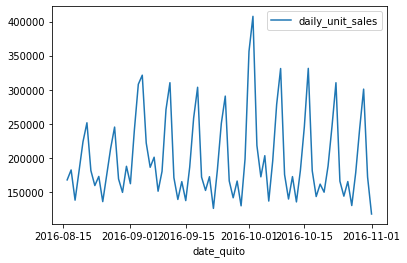

In [13]:
# 1. Plot all daily unit sales
daily_unit_sales = stores.groupBy('date_quito').sum('unit_sales').toPandas()
print(daily_unit_sales.head())
daily_unit_sales.rename(columns={'sum(unit_sales)': 'daily_unit_sales'}, inplace=True)
daily_unit_sales.plot(x='date_quito', y='daily_unit_sales')

In [14]:
# 2. Boxplot of unit_sales grouped by holiday
# Join holidays and stores on their dates

In [15]:
# NEVER FORGET to stop the session
DONE = False
if DONE:
    spark.stop()